# **1. Data Loading**

In [7]:
# enable importing nflmodels package
import sys
sys.path.append('..') 


import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, cohen_kappa_score, roc_auc_score, mean_squared_error, log_loss, RocCurveDisplay, f1_score

import xgboost as xgb

import seaborn as sns
sns.set_style('whitegrid')

pd.set_option('display.max_columns', None)

from joblib import dump, load

# DEV: reload modules
import importlib
importlib.reload(sys.modules.get('nflmodels.preprocessing', sys))
importlib.reload(sys.modules.get('nflmodels.models', sys))
importlib.reload(sys.modules.get('nflmodels.validation', sys))
importlib.reload(sys.modules.get('nflmodels.dataloader.pgloader', sys))

from nflmodels.preprocessing import preprocess_next_play, preprocess_field_goal, preprocess_ep
from nflmodels.models import FieldGoalModel, NextPlayModel, EPModel
from nflmodels.validation import valplot_fieldgoal, valplot_nextplay, valplot_ep
from nflmodels.dataloader import PgLoader

In [8]:
import os
from dotenv import load_dotenv
load_dotenv()

credentials = {
    'user': os.environ['USER'],
    'password': os.environ['PASSWORD'],
    'host': os.environ['HOST'],
    'port': os.environ['PORT'],
    'dbname': os.environ['DBNAME'],
    'tablename': os.environ['TABLENAME']
}

loader = PgLoader(credentials=credentials)
df = loader.select(select_preset=True, columns=['qb_hit', 'sack', 'penalty_player_name', 'penalty_type', 'passer_player_name', 'qb_hit_1_player_name', 'qb_hit_2_player_name', 
                          'sack_player_name', 'half_sack_1_player_name', 'half_sack_2_player_name',]).where('season >= 2010').load()


SELECT play_id, game_id, home_team, away_team, posteam, posteam_type, defteam, yardline_100, quarter_seconds_remaining, half_seconds_remaining, game_seconds_remaining, quarter_end, drive, sp, qtr, game_half, down, goal_to_go, yrdln, ydstogo, ydsnet, play_type, yards_gained, shotgun, no_huddle, qb_dropback, qb_kneel, qb_spike, qb_scramble, pass_length, pass_location, air_yards, yards_after_catch, run_location, run_gap, field_goal_result, kick_distance, extra_point_result, two_point_conv_result, posteam_timeouts_remaining, defteam_timeouts_remaining, timeout, timeout_team, td_team, posteam_score, defteam_score, score_differential, posteam_score_post, defteam_score_post, score_differential_post, ep, epa, wp, def_wp, home_wp, away_wp, wpa, penalty, safety, interception, touchdown, pass_touchdown, rush_touchdown, return_touchdown, extra_point_attempt, two_point_attempt, field_goal_attempt, kickoff_attempt, punt_attempt, complete_pass, penalty_team, penalty_yards, season, drive_ended_with_sc

c:\users\eemeli\documents\github\nflmodels\nflmodels\dataloader\pgloader.py:70: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql=query, con=conn)


# **2. Play Type Prediction - ML**

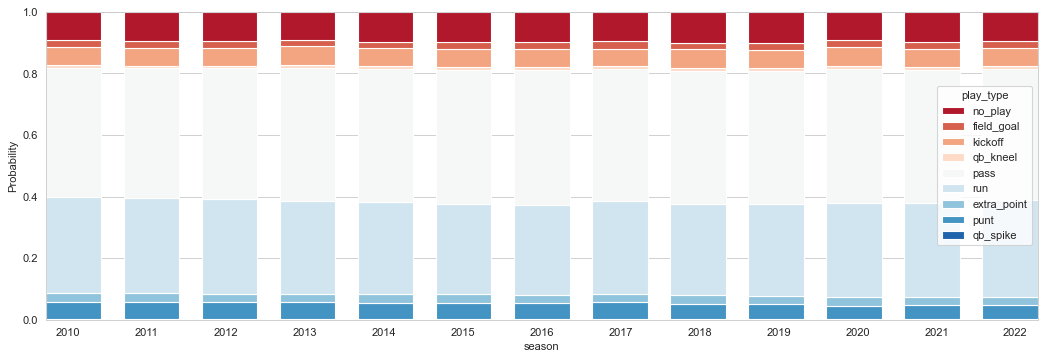

In [5]:
# plot play types per season
fig, ax = plt.subplots(figsize=(16,5), dpi=80)
sns.histplot(data=df, x='season', hue='play_type', stat='probability', multiple='fill', shrink=5, palette='RdBu', ax=ax, alpha=1)
ax.set_xticks([*range(df['season'].min(), df['season'].max() + 1, 1)])
plt.show()

Play types are distributed similarly in all seasons featured here.

In [5]:
# # preliminary testing shows that weighting only increased the errors in past seasons, does not really influence performance on recent data
# USE_SAMPLE_WEIGHTS = False

# if USE_SAMPLE_WEIGHTS:
#     # create sample weights
#     df_plays['sample_weights'] = 1

#     n_of_seasons = df_plays['season'].max() - df_plays['season'].min() + 1

#     for i in range(n_of_seasons):
#         season = df_plays['season'].max() - i
#         #sample_weights['sample_weights'] = np.where(sample_weights['season'] == season, 1 / n_of_seasons * (n_of_seasons - i), sample_weights['sample_weights'])
#         # if i < 3:
#         df_plays['sample_weights'] = np.where(df_plays['season'] == season,  5 / (n_of_seasons ** 2) * ((n_of_seasons - i) ** 2), df_plays['sample_weights'])
#         # else:
#         #     sample_weights['sample_weights'] = np.where(sample_weights['season'] == season,  1 / 169 * ((n_of_seasons - i) * (n_of_seasons - i)), sample_weights['sample_weights'])
# else:
#     df_plays['sample_weights'] = 1


In [6]:
# subquery_args = [
# #    'season >= 2022',
# #    'posteam == "KC"'
# ]

# subquery = ' and '.join(subquery_args)

# # Feature selection --------------------

# features = [
#     'sample_weights',
#     #'posteam_score', 
#     #'defteam_score', 
#     'score_differential', 
#     'qtr', 
#     'game_seconds_remaining', 
#     'half_seconds_remaining', 
#     'down', 
#     'yardline_100', 
#     'ydstogo', 
#     'goal_to_go', 
#     'posteam_timeouts_remaining', 
#     'defteam_timeouts_remaining', 
#     'posteam_type', 
#     'shotgun',
#     #'posteam',
#     #'defteam',
#     ]

# if subquery == '':
#     y = df_plays['play_type']
#     X = df_plays[features]
# else:
#     y = df_plays.query(subquery)['play_type']
#     X = df_plays.query(subquery)[features]

# # Feature engineering ------------------

# # - encode categoricals
# X = pd.get_dummies(X, columns=[
#     'qtr', 
#     'down', 
#     'posteam_timeouts_remaining', 
#     'defteam_timeouts_remaining', 
#     #'posteam',
#     #'defteam',
#     ])

# sample_weights = X['sample_weights'].to_numpy()
# X.drop('sample_weights', axis=1, inplace=True)

### Train-val-test

In [8]:
X, y, labels = preprocess_next_play(data=df, seasons=[], return_X_y=True, map_target_to_int=True, include_fg=True, include_qbkneel=False, include_qbspike=False, verbose=True)

# split train_val_test 60-20-20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

Preprocessing 632196 rows...
Preprocessing for play types: ['pass', 'run', 'field_goal', 'punt']
Dropped 1263 rows containing NaN values.
Resulting dataset size is 485984 rows.
Encoding play types as integers...
Returned preprocessed X, y, play_types


### XGBClassifier

On validation set
ROC AUC: 0.848
F1 score: 0.750
MSE: 0.258
Log loss: 0.498


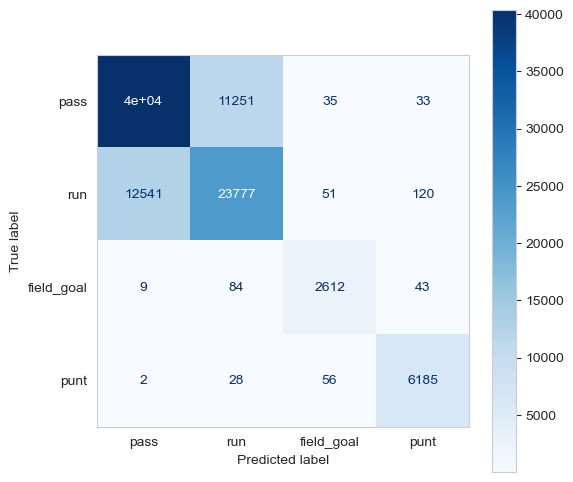

              precision    recall  f1-score   support

           0       0.76      0.78      0.77     51689
           1       0.68      0.65      0.66     36489
           2       0.95      0.95      0.95      2748
           3       0.97      0.99      0.98      6271

    accuracy                           0.75     97197
   macro avg       0.84      0.84      0.84     97197
weighted avg       0.75      0.75      0.75     97197

Cohen kappa score: 0.562


In [9]:
model = NextPlayModel()
model.fit(X_train, y_train)
y_pred, y_pred_proba = model.validate(X_val, y_val)
valplot_nextplay(X_val, y_val, y_pred, y_pred_proba, labels=labels)

# **3. Field Goal Success Prediction - ML**

### Preprocess & Train test split

In [10]:
X, y = preprocess_field_goal(data=df, kickers='active', return_X_y=True)

# Split train-val-test: 70%/12.5%/12.5%
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5)

### Model training

On validation set
ROC AUC: 0.805
MSE: 0.094
Log loss: 0.257


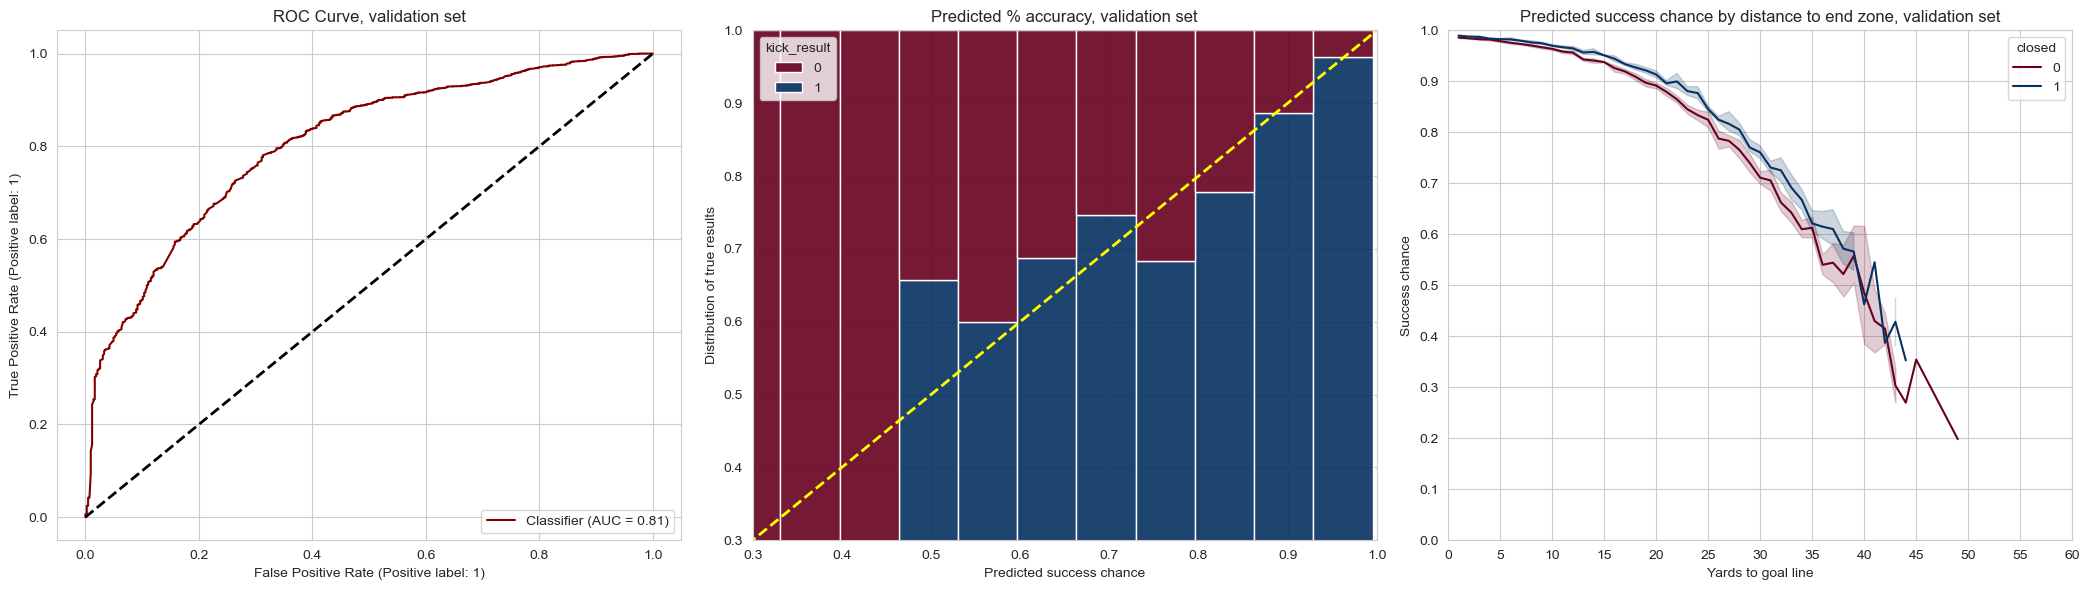

In [11]:
model = FieldGoalModel()
model.fit(X_train, y_train)
y_pred, y_pred_proba = model.validate(X_val, y_val)
valplot_fieldgoal(X_val, y_val, y_pred, y_pred_proba)

In [12]:
# 1. Retrain using train + val
# 2. Test on test set
# 3. Save model using joblib

model_fg = FieldGoalModel()
model_fg.fit(pd.concat([X_train, X_val], axis=0), pd.concat([y_train, y_val], axis=0))

# Predict on test set
y_pred, y_pred_proba = model_fg.validate(X_test, y_test)

# Save model to disk
#dump(clf_fg, 'clf_fg.joblib')
#print('Model saved!')
#load('clf_fg.joblib') # to load saved model

On validation set
ROC AUC: 0.805
MSE: 0.091
Log loss: 0.255


### Using the Model

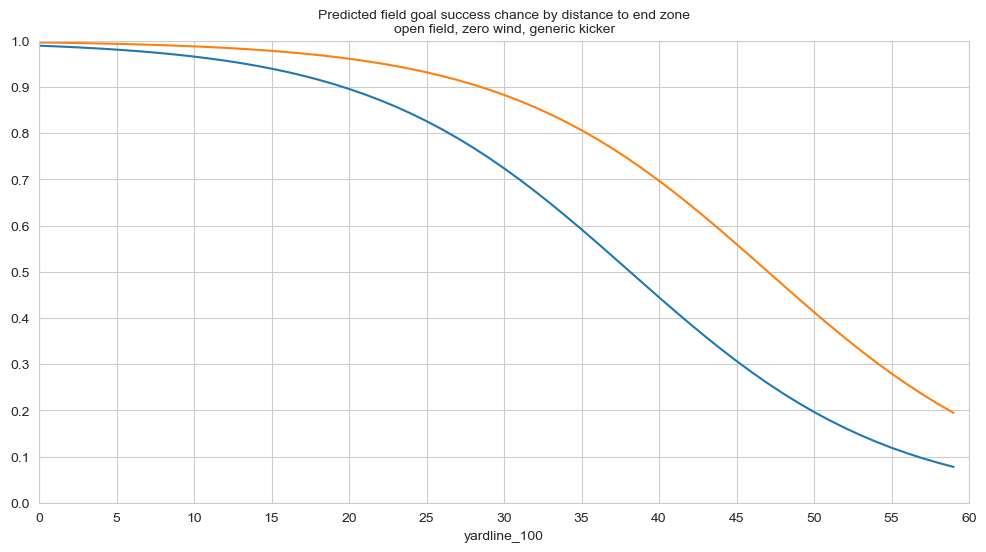

In [14]:
# simulated kicks, open air field, no wind, generic kicker
ydline = [*range(0, 60, 1)]
pred_df = pd.DataFrame({'yardline_100': ydline})
for i in range(1, len(model_fg.classifier.feature_names_in_)): #start from 1 to skip yardline
    pred_df[model_fg.classifier.feature_names_in_[i]] = 0
pred_df['kicker_player_name_Other'] = 1 #use other player for all predictions
#pred_df['closed'] = 1
#pred_df['wind'] = 15

pred_res = model_fg.classifier.predict_proba(pred_df)[:,1]#.reshape(-1, 1)

# J.Tucker
pred_df['kicker_player_name_Other'] = 0
pred_df['kicker_player_name_J.Tucker'] = 1
pred_res_jt = model_fg.classifier.predict_proba(pred_df)[:,1]

# plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(ax=ax, data=pred_df, x='yardline_100', y=pred_res)
sns.lineplot(ax=ax, data=pred_df, x='yardline_100', y=pred_res_jt)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
ax.set_ylim(0, 1)
ax.set_xlim(0, 60)
ax.set_title('Predicted field goal success chance by distance to end zone\nopen field, zero wind, generic kicker', size=10)
plt.show()

# **4. EP & EPA**

ep = expected points

In [15]:
df.info()
# [['game_id', 'play_id', 'qtr', 'game_half', 'posteam', 'defteam', 'drive', 'down', 'yardline_100', 'play_type', 
#                               'penalty', 'timeout', 'sp', 'posteam_score', 'defteam_score', 'play_score_gained', 'next_score', 'ep', 'epa']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632196 entries, 0 to 632195
Data columns (total 93 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   play_id                     632196 non-null  int64  
 1   game_id                     632196 non-null  object 
 2   home_team                   632196 non-null  object 
 3   away_team                   632196 non-null  object 
 4   posteam                     585964 non-null  object 
 5   posteam_type                585964 non-null  object 
 6   defteam                     585964 non-null  object 
 7   yardline_100                579374 non-null  float64
 8   quarter_seconds_remaining   631642 non-null  float64
 9   half_seconds_remaining      631642 non-null  float64
 10  game_seconds_remaining      631642 non-null  float64
 11  quarter_end                 632196 non-null  int64  
 12  drive                       622461 non-null  float64
 13  sp            

In [16]:
# TODO: temp, remove after not needed
importlib.reload(sys.modules.get('nflmodels.preprocessing', sys))
from nflmodels.preprocessing import preprocess_ep

X_n, y_n, X_pat, y_pat = preprocess_ep(data=df)

Preprocessing 632196 rows...
After dropping some rows, dataset size is 578974
All 578974 out of 578974 rows processed!
Final dataset size is 578951 rows


In [17]:
# Split train-val-test: 70%/12.5%/12.5%
X_train, X_val, y_train, y_val = train_test_split(X_n, y_n, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5)

In [18]:
model = EPModel()
model.fit(X_train, y_train)
y_pred, y_pred_proba = model.validate(X_val, y_val)

c:\Users\Eemeli\mambaforge\envs\ds-nfl\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [9]:
y_pred = model.classifier.predict(X_val)
y_pred_proba = model.classifier.predict_proba(X_val)

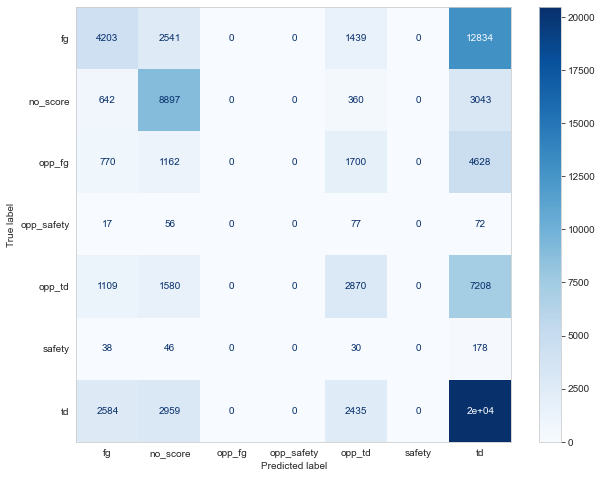

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, ax=ax, cmap='Blues')
ax.grid(False)
plt.show()

### Temp Notes:

In [61]:
#df_ep.query('extra_point_attempt == 0 and two_point_attempt == 0')['next_score'].value_counts()
df_ep['next_score'].value_counts()

td            187904
fg            140240
no_score       87539
opp_td         85234
opp_fg         55300
safety          1933
opp_safety      1500
Name: next_score, dtype: int64

In [62]:
df_pat['next_score'].value_counts()

pat              16156
no_score          1321
2pat               696
opp_patreturn       11
Name: next_score, dtype: int64

In [56]:
df_ep.query('extra_point_attempt == 1 or two_point_attempt == 1')['next_score'].value_counts()

pat              15959
no_score          1321
2pat               623
opp_patreturn       11
Name: next_score, dtype: int64

In [55]:
df_ep['next_score_value'].value_counts()

 6    187904
 3    140240
 0     88860
-6     85234
-3     55300
 1     16156
 2      2629
-2      1511
Name: next_score_value, dtype: int64

In [22]:
df_ep.query('field_goal_attempt == 1')[['next_score','sp','yardline_100', 'play_score_gained','ep','epa', 'play_type']].head(60)

,next_score,sp,yardline_100,play_score_gained,ep,epa,play_type
13,opp_fg,0,16.0,None,2.690119,-4.517740,field_goal
40,fg,1,4.0,3.0,2.937339,0.062661,field_goal
63,fg,1,28.0,3.0,1.932867,1.067133,field_goal
108,fg,1,7.0,3.0,2.890051,0.109949,field_goal
192,fg,1,34.0,3.0,0.835992,2.164008,field_goal
245,fg,0,28.0,None,1.843330,-3.219873,field_goal
253,opp_fg,0,37.0,None,1.155874,-1.864610,field_goal
257,fg,1,31.0,3.0,1.994863,1.005137,field_goal
272,fg,1,21.0,3.0,2.336894,0.663106,field_goal
280,fg,1,18.0,3.0,2.410303,0.589697,field_goal


One possibility would be to assess extra point attempts differently and obtain a reasonable expectation on the value. Then this value would be used with tds to increase their value and drop extra point attempts completely...?

Issues:
nflverse says that the value of a touchdown is always seven, meaning that on a td ep+epa=7

In [23]:
#df_ep.query('game_id == "2022_18_TEN_JAX"').groupby('posteam')['epa'].sum()
df_ep.query('season == 2022 and play_score_gained == 3')[['ep', 'epa']].head(30)

,ep,epa
533297,2.948091,0.051909
533342,2.193322,0.806678
533479,2.222366,0.777634
533507,1.772887,1.227113
533666,2.921587,0.078413
533685,2.723580,0.276420
533720,2.608476,0.391524
533741,2.734776,0.265224
533749,1.204142,1.795858
533771,2.842867,0.157133


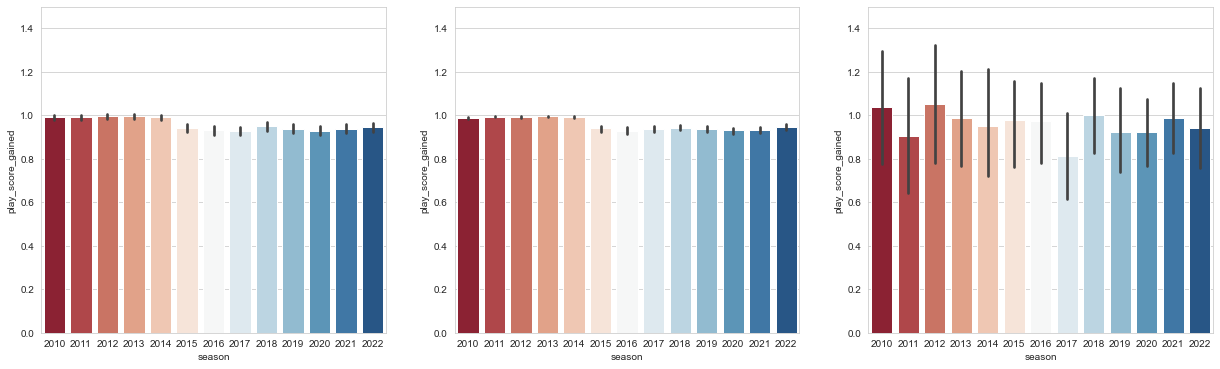

In [30]:
#df_ep.query('extra_point_attempt == 1 or two_point_attempt == 1')['play_score_gained'].mean()
fig, ax = plt.subplots(1, 3, figsize=(21, 6))
sns.barplot(data=df_ep.query('extra_point_attempt == 1 or two_point_attempt == 1'), x='season', y='play_score_gained', ax=ax[0], palette='RdBu')
ax[0].set_ylim(0, 1.5)
sns.barplot(data=df_ep.query('extra_point_attempt == 1'), x='season', y='play_score_gained', ax=ax[1], palette='RdBu')
ax[1].set_ylim(0, 1.5)
sns.barplot(data=df_ep.query('two_point_attempt == 1'), x='season', y='play_score_gained', ax=ax[2], palette='RdBu')
ax[2].set_ylim(0, 1.5)
plt.show()

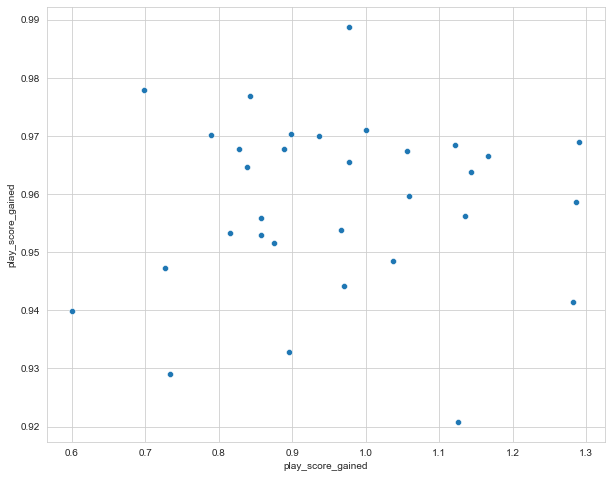

In [49]:
#df_ep.query('extra_point_attempt == 1').groupby(by='posteam')['play_score_gained'].mean()
#df_ep.query('two_point_attempt == 1 and season >= 2021').groupby(by='posteam')['play_score_gained'].mean()
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(
    y=df_ep.query('extra_point_attempt == 1').groupby(by='posteam')['play_score_gained'].mean(), 
    x=df_ep.query('two_point_attempt == 1').groupby(by='posteam')['play_score_gained'].mean(),
    #hue=df_ep['posteam'].unique()
)
plt.show()